In [2]:
extensions_loaded = False
if not extensions_loaded:
    %load_ext autoreload
    %load_ext tensorboard
    extensions_loaded = True

%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
import sys

import so_ml_tools as soml

import opendatasets as od
import tensorflow as tf
import pandas as pd
import datetime
import shap
import math
import keras_tuner as kt
from keras_tuner import HyperParameter
from keras import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Input, Activation
from keras.losses import mean_absolute_error, mean_squared_error
from keras.callbacks import TensorBoard
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler, Normalizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from keras.regularizers import l1, l2
from sklearn import set_config

2023-09-07 16:01:37.782651: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-07 16:01:37.801684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 16:01:38.204083: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Download the dataset from Kaggle (kaggle.json API key neccesary)

In [6]:
# Download the dogs and cats dataset
od.download_kaggle_dataset(dataset_url="https://www.kaggle.com/datasets/tugberkkaran/used-car-listings-features-and-prices-carscom/download?datasetVersionNumber=1",
                           data_dir="./data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  ronaldmathies


Your Kaggle Key:

  ········


100%|██████████████████████████████████████| 1.00M/1.00M [00:00<00:00, 1.84MB/s]

# CSV File Definition

let's first get an overview of the definition of all the columns:

* brand: Brand of the car.
* model: Model of the car.
* year: Year of production of the car.
* mileage: Mileage of the car.
* engine: Information about the car's engine.
* engine_size: Size of the car's engine.
* transmission: Type of transmission of the car.
* automatic_transmission: A binary value indicating the presence of automatic transmission (1: Yes, 0: No).
* fuel_type: Fuel type of the car.
* drivetrain: Drivetrain type of the car.
* min_mpg: Minimum fuel efficiency of the car.
* max_mpg: Maximum fuel efficiency of the car.
* damaged: A binary value indicating the presence of damage in the car (1: Yes, 0: No).
* first_owner: Is the car a 1-owner vehicle? (1: Yes, 0: No).
* personal_using: Is the car for personal use only? (1: Yes, 0: No).
* turbo: A binary value indicating the presence of a turbocharger in the car (1: Yes, 0: No).
* alloy_wheels: Are there alloy wheels on the car? (1: Yes, 0: No).
* adaptive_cruise_control: A binary value indicating the presence of adaptive cruise control (1: Yes, 0: No).
* navigation_system: A binary value indicating the presence of a navigation system (1: Yes, 0: No).
* power_liftgate: A binary value indicating the presence of a power liftgate (1: Yes, 0: No).
* backup_camera: A binary value indicating the presence of a backup camera (1: Yes, 0: No).
* keyless_start: A binary value indicating the presence of keyless start system (1: Yes, 0: No).
* remote_start: A binary value indicating the presence of a remote start system (1: Yes, 0: No).
* sunroof/moonroof: A binary value indicating the presence of a sunroof/moonroof (1: Yes, 0: No).
* automatic_emergency_braking: A binary value indicating the presence of automatic emergency braking system (1: Yes, 0: No).
* stability_control: A binary value indicating the presence of stability control system (1: Yes, 0: No).
* leather_seats: Are there leather seats in the car? (1: Yes, 0: No).
* memory_seat: Are there memory seats in the car? (1: Yes, 0: No).
* third_row_seating: A binary value indicating the presence of third row seating (1: Yes, 0: No).
* apple_car_play/android_auto: A binary value indicating the presence of Apple CarPlay / Android Auto integration (1: Yes, 0: No).
* bluetooth: A binary value indicating the presence of Bluetooth connectivity (1: Yes, 0: No).
* usb_port: A binary value indicating the presence of USB ports (1: Yes, 0: No).
* heated_seats: Are there heated seats in the car? (1: Yes, 0: No).
* interior_color: Interior color of the car.
* exterior_color: Exterior color of the car.
* price: Price of the car. This feature is the target feature of this dataset.

# Inspect the contents of the downloaded dataset

In [7]:
train_csv_file = "./data/used-car-listings-features-and-prices-carscom/train.csv"
test_csv_file = "./data/used-car-listings-features-and-prices-carscom/test.csv"

In [8]:
# Load the training and test data
train_csv = pd.read_csv(train_csv_file)
test_csv = pd.read_csv(test_csv_file)

train_csv[:5]

,brand,model,year,mileage,engine,engine_size,transmission,automatic_transmission,fuel_type,drivetrain,...,leather_seats,memory_seat,third_row_seating,apple_car_play/android_auto,bluetooth,usb_port,heated_seats,interior_color,exterior_color,price
0,Mazda,CX-9 Touring,2022.0,6580.0,2.5L I4 16V GDI DOHC Turbo,2.5,6-Speed Automatic,1.0,Gasoline,Four-wheel Drive,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,Black,Snowflake White Pearl,36789
1,Alfa,Romeo Stelvio 4DR SUV AWD,2018.0,62717.0,Twin Turbo Premium Unleaded V-6 2.9 L/176,2.9,Automatic,1.0,Gasoline,Four-wheel Drive,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,Black,Rosso Competizione Tri-Coat,39993
2,Chevrolet,Silverado 1500 Limited LT,2022.0,15463.0,5.3L V8 16V GDI OHV,5.3,Automatic,1.0,Gasoline,Four-wheel Drive,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Jet Black,Silver Ice Metallic,46986
3,Land,Rover Range Rover P400 SE,2022.0,1281.0,3.0L I6 24V GDI DOHC Turbo,3.0,Automatic,1.0,Gasoline,Four-wheel Drive,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,Ebony,Fuji White,141999
4,Mitsubishi,Outlander Sport 2.0 SE,2021.0,36727.0,2.0L I4 16V MPFI DOHC,2.0,Automatic CVT,1.0,Gasoline,Front-wheel Drive,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,Black,White,21595


# Inspect column attributes like type, null / not-null columns, distribution, outliers, etc...

In [10]:
soml.pandas.dataframe.describe(train_csv)

Total number of rows: 19109


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,brand,object,19107,2,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,model,object,19107,2,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,year,float64,19107,2,59,2017.77,5.00,2002.78,2032.76,1962.0,2016.0,2019.0,2021.0,2024.0
3,mileage,float64,19107,2,17412,47947.09,38285.06,-66908.10,162802.27,0.0,19307.0,39141.0,68431.5,383614.0
4,engine,object,19062,47,1163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,engine_size,float64,17860,1249,62,2.97,5.48,-13.46,19.41,0.0,2.0,2.5,3.5,390.0
6,transmission,object,19004,105,189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,automatic_transmission,float64,19107,2,2,0.92,0.28,0.09,1.74,0.0,1.0,1.0,1.0,1.0
8,fuel_type,object,19107,2,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,drivetrain,object,19107,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# <span style="color:green">Column brand</span>

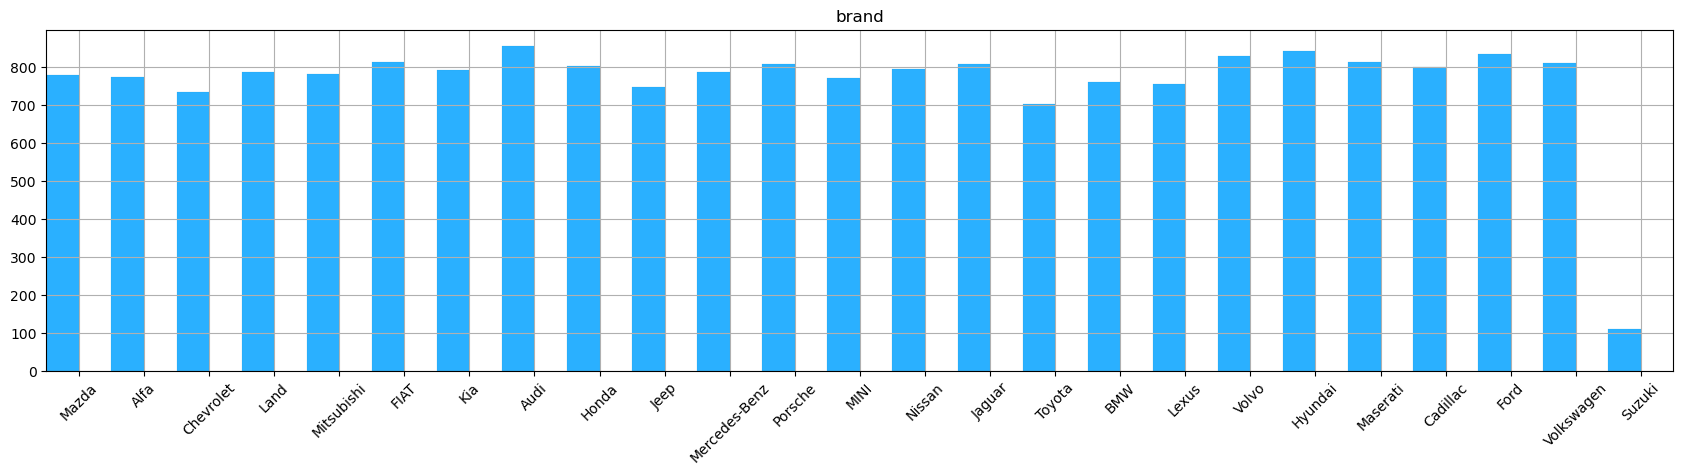

Total number of rows: 19109


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,brand,object,19107,2,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
soml.pandas.plot.histogram_for_columns(train_csv, column_names="brand")
brand_desc = soml.pandas.dataframe.describe(train_csv, column_names="brand")
brand_desc

25 unique values for the brand names, with 2 missing values, brand name can have a big influence on the car price so we will hot-encode them, and remove the two rows with the missing values.

In [12]:
# Delete the rows where the brand column is empty.
soml.pandas.dataframe.delete_null_rows(dataframe=train_csv, column_name='brand', inplace=True)
soml.pandas.dataframe.delete_null_rows(dataframe=test_csv, column_name='brand', inplace=True)

# Create a one-hot encoder for transforming the data.
brand_pipeline = Pipeline(steps=[
    ("brand-ohe", OneHotEncoder())
])

# <span style="color:green">Column model</span>

In [13]:
soml.pandas.plot.histogram_for_columns(train_csv, column_names="model")
model_desc = soml.pandas.dataframe.describe(train_csv, column_names="model")
model_desc

Column 'model' is not visualized, the number of nunique values (3498) either exceeds 50 or is lower then 3.


<Figure size 1700x400 with 0 Axes>

Total number of rows: 19107


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,model,object,19107,0,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The model contains a high variety of values which if we would use one-hot encoding would lead to a large number of values, for now we skip this column and we remove it from the
dataset.

In [12]:
# When calling .transform the column will be dropped automatically.
# mld.dataframe_drop_columns(train_csv, 'model')

# <span style="color:green">Column year</span>

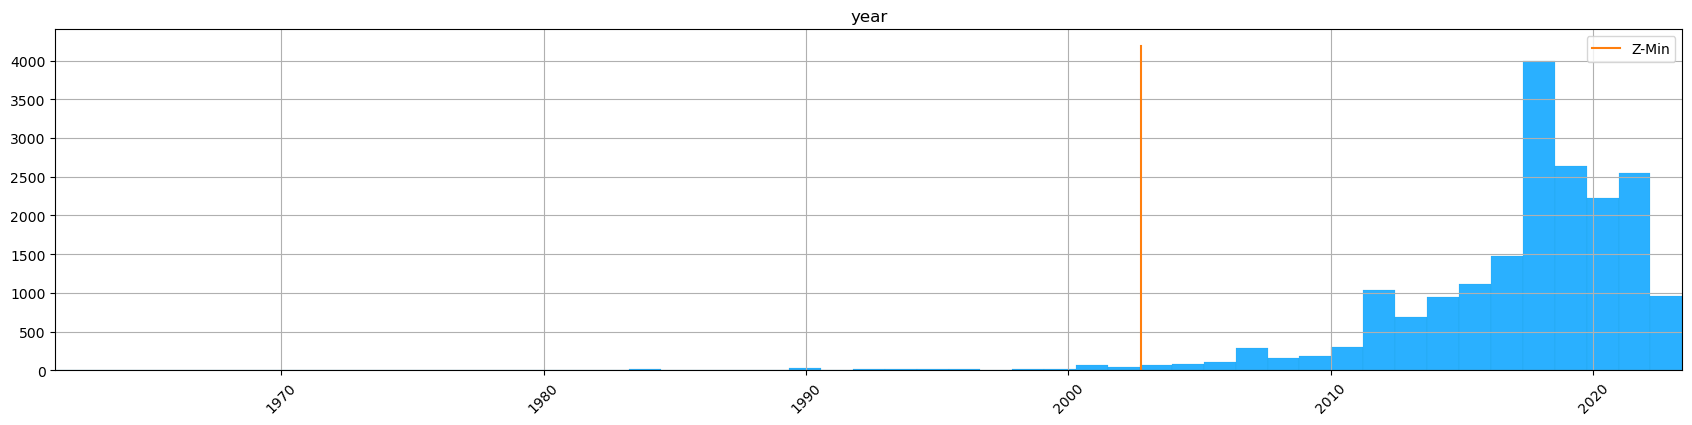

Total number of rows: 19107


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,year,float64,19107,0,59,2017.77,5.0,2002.78,2032.76,1962.0,2016.0,2019.0,2021.0,2024.0


In [13]:
mlp.plot_histogram_from_dataframe(train_csv, column_names="year")
year_desc = soml.pandas.dataframe.describe(train_csv, column_names="year")
year_desc

The production year is wel represented in the last two decades, the further we go back the fewer rows we have and they become outliers. For now we will remove records with a Z-Score of 2002 based on the -3 * Std. And we will also apply normalization.

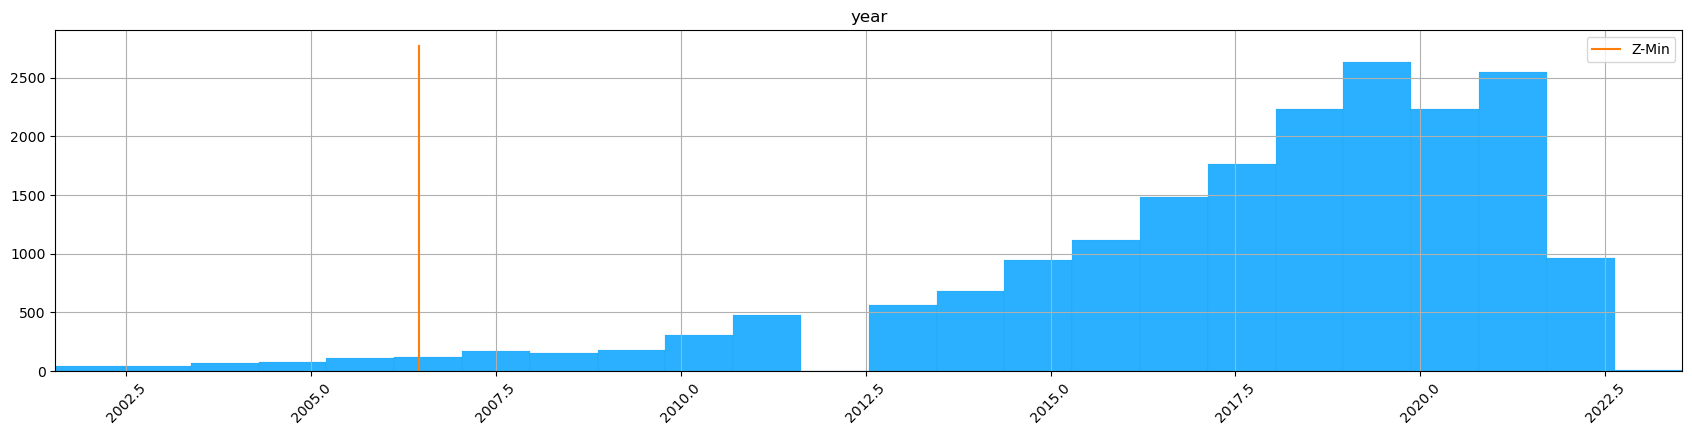

Total number of rows: 18880


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,year,float64,18880,0,23,2018.1,3.88,2006.46,2029.74,2002.0,2016.0,2019.0,2021.0,2024.0


In [14]:
train_csv.drop(train_csv[train_csv['year'] < math.floor(year_desc["Z-Min"][0])].index, inplace = True)
test_csv.drop(test_csv[test_csv['year'] < math.floor(year_desc["Z-Min"][0])].index, inplace = True)

soml.pandas.plot.histogram_for_columns(train_csv, column_names="year")
soml.pandas.dataframe.describe(train_csv, column_names="year")

In [15]:
year_pipeline = Pipeline(steps=[
    ("year_sc", MinMaxScaler())
])

# <span style="color:green">Column mileage</span>

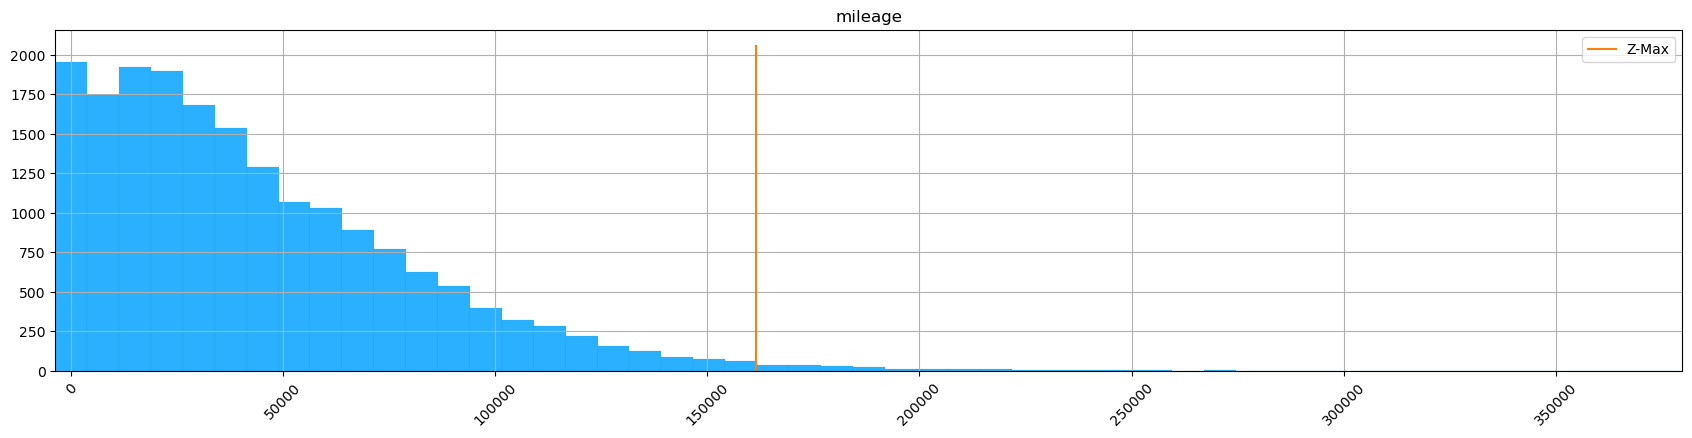

Total number of rows: 18880


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,mileage,float64,18880,0,17215,47589.76,37953.97,-66272.15,161451.67,0.0,19213.0,38827.0,68003.25,383614.0


In [16]:
soml.pandas.plot.histogram_for_columns(train_csv, column_names="mileage")
mileage_desc = soml.pandas.dataframe.describe(train_csv, column_names="mileage")
mileage_desc

The milage of the cars are mostly below the 150.000, but we do have outliers up to 380.000. The Z-Score of 162.000 seems to be a nice cut-off point for removing outliers so we will do that first. Then we will use a standard scalar to scale the values.

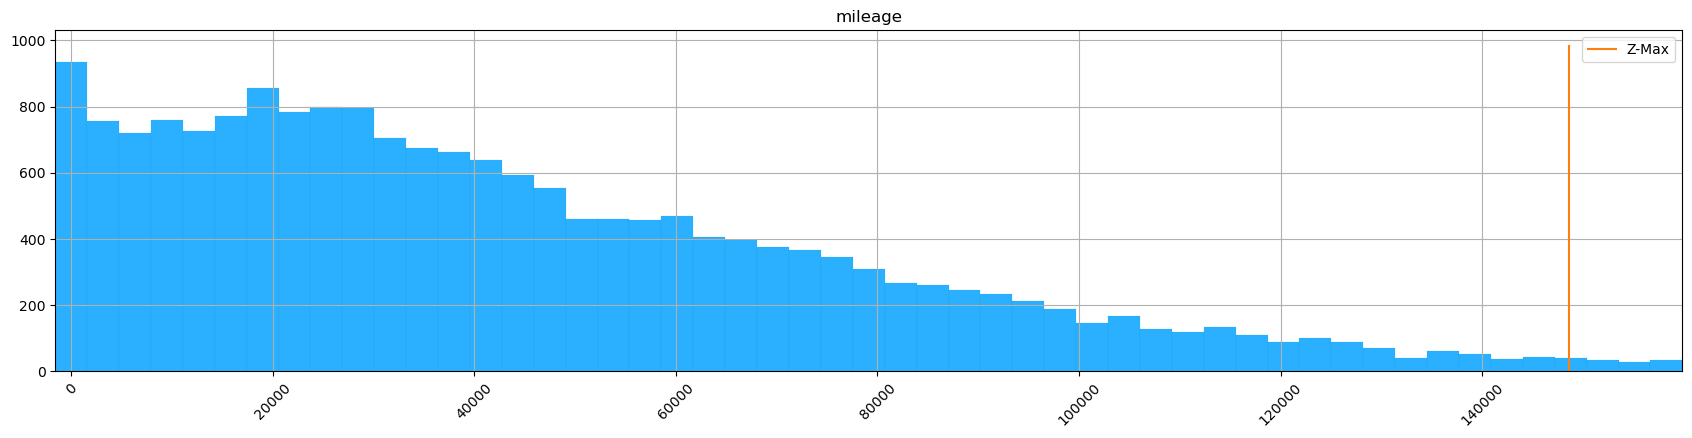

Total number of rows: 18652


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,mileage,float64,18652,0,16987,45789.54,34275.11,-57035.8,148614.88,0.0,18983.75,38199.5,66571.75,161447.0


In [17]:
train_csv.drop(train_csv[train_csv['mileage'] > mileage_desc["Z-Max"][0]].index, inplace = True)
test_csv.drop(test_csv[test_csv['mileage'] > mileage_desc["Z-Max"][0]].index, inplace = True)
soml.pandas.plot.histogram_for_columns(train_csv, column_names="mileage")
soml.pandas.dataframe.describe(train_csv, column_names="mileage")

In [18]:
mileage_pipeline = Pipeline(steps=[
    ("mileage_sc", MinMaxScaler())
])

# <span style="color:green">Column engine</span>

In [19]:
soml.pandas.plot.histogram_for_columns(train_csv, column_names="engine")
mileage_desc = soml.pandas.dataframe.describe(train_csv, column_names="engine")
mileage_desc

Column 'engine' is not visualized, the number of nunique values (1023) either exceeds 50 or is lower then 3.


<Figure size 1700x400 with 0 Axes>

Total number of rows: 18652


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,engine,object,18623,29,1023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This again is a column with a high number of unique values, we can check the unique values to see if they are interesting or not, but transforming them to one-hot encoding is probably not a good idea, for now we are going to remove this column.

In [20]:
train_csv["engine"].unique()

array(['2.5L I4 16V GDI DOHC Turbo',
       'Twin Turbo Premium Unleaded V-6 2.9 L/176', '5.3L V8 16V GDI OHV',
       ..., 'VQ 3.5L V-6 DOHC, variable valve control, engine with 287HP',
       'Gas/Electric I-4 2.5 L/152', 'Premium Unleaded V-8 5.6 L/339'],
      dtype=object)

In [21]:
# When calling .transform the column will be dropped automatically.
# mld.dataframe_drop_columns(train_csv, 'engine')

# <span style="color:green">Column engine_size</span>

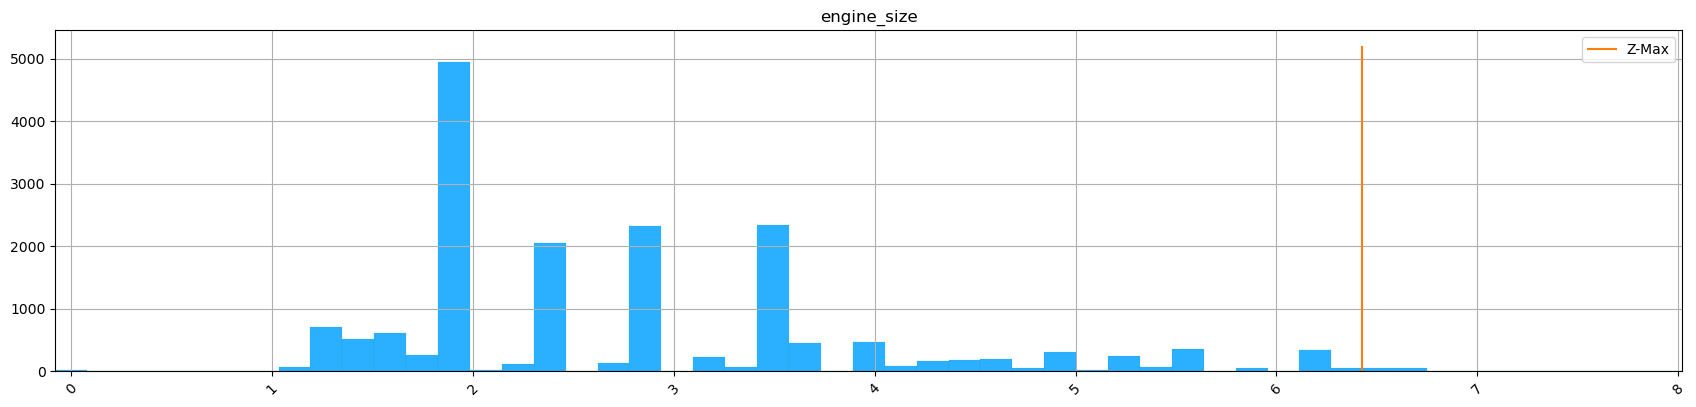

Total number of rows: 18652


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,engine_size,float64,17450,1202,53,2.87,1.18,-0.68,6.43,0.0,2.0,2.5,3.5,8.1


In [22]:
soml.pandas.plot.histogram_for_columns(train_csv, column_names="engine_size")
engine_size_desc = soml.pandas.dataframe.describe(train_csv, column_names="engine_size")
engine_size_desc

Engine size looks actually quite good, there are some outliers on the right after 6.43, there is not much to wrong here. So we just clean up the outliers a bit, and then use a standard scaling. We also need to handle the Null values, for this we can use an imputer.

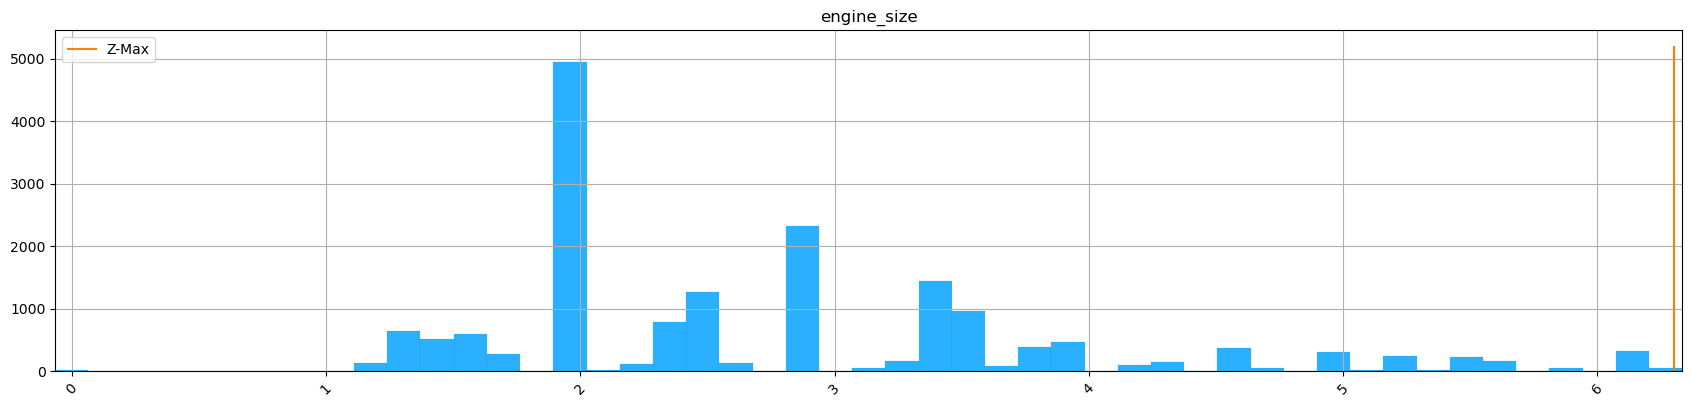

Total number of rows: 18551


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,engine_size,float64,17349,1202,48,2.85,1.15,-0.6,6.3,0.0,2.0,2.5,3.5,6.4


In [23]:
train_csv.drop(train_csv[train_csv['engine_size'] > engine_size_desc["Z-Max"][0]].index, inplace = True)
test_csv.drop(test_csv[test_csv['engine_size'] > engine_size_desc["Z-Max"][0]].index, inplace = True)
soml.pandas.plot.histogram_for_columns(train_csv, column_names="engine_size")
soml.pandas.dataframe.describe(train_csv, column_names="engine_size")

In [24]:
engine_size_pipeline = Pipeline(steps=[
    ("engine_size_im", SimpleImputer()),
    ("engine_size_sc", MinMaxScaler())
])

# <span style="color:green">Column transmission</span>

In [25]:
soml.pandas.plot.histogram_for_columns(train_csv, column_names="transmission")
transmission_desc = soml.pandas.dataframe.describe(train_csv, column_names="transmission")
transmission_desc

Column 'transmission' is not visualized, the number of nunique values (179) either exceeds 50 or is lower then 3.


<Figure size 1700x400 with 0 Axes>

Total number of rows: 18551


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,transmission,object,18467,84,179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


So we have 178 unique string values, so one-hot encoding these is not that great of an idea. there are other options out there (target encoding, count, catboost, etc.. these are part of the category encoders: http://contrib.scikit-learn.org/category_encoders/ ), for now, we will remove this column.

In [26]:
# When calling .transform the column will be dropped automatically.
# mld.dataframe_drop_columns(train_csv, 'transmission')

# <span style="color:green">Column fuel_type</span>

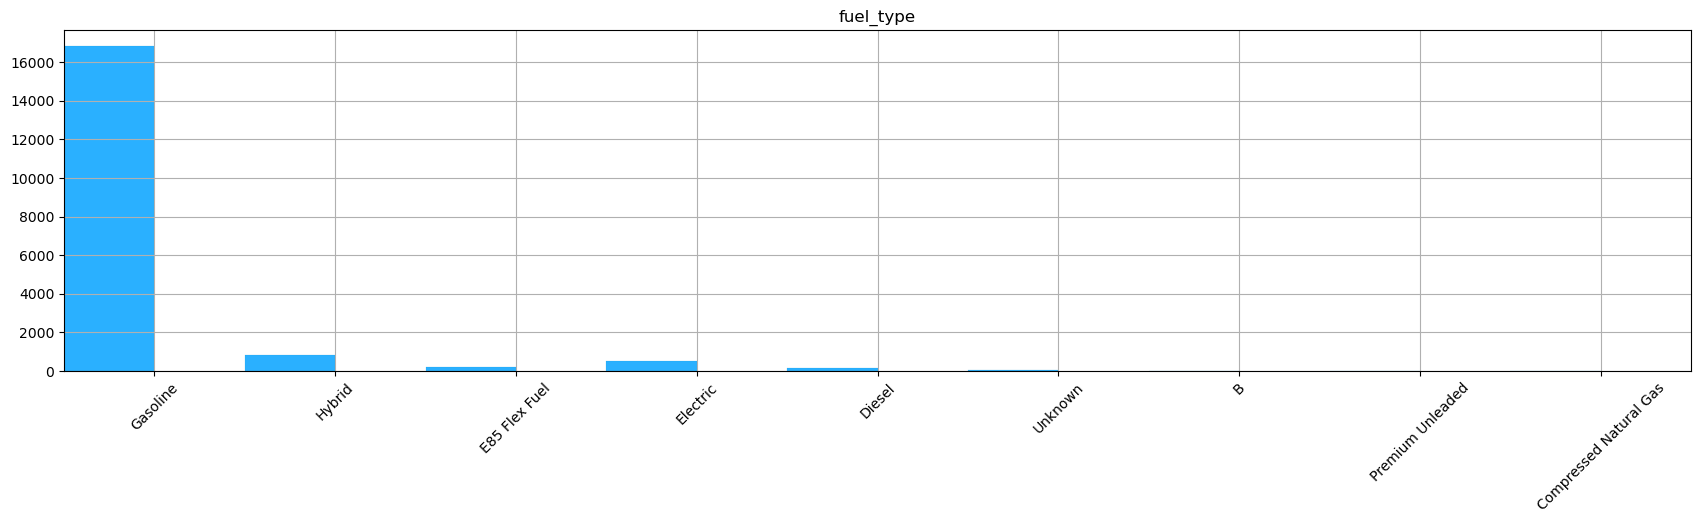

Total number of rows: 18551


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,fuel_type,object,18551,0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
soml.pandas.plot.histogram_for_columns(train_csv, column_names="fuel_type")
fuel_type_desc = soml.pandas.dataframe.describe(train_csv, column_names="fuel_type")
fuel_type_desc

Here we have 9 categories of fuel type, the most interesting fact is that gasoline i over-represented, let's group them together and see how many of each class we have.

In [28]:
train_csv['fuel_type'].value_counts()

fuel_type
Gasoline                  16807
Hybrid                      833
Electric                    518
E85 Flex Fuel               193
Diesel                      152
Unknown                      45
B                             1
Premium Unleaded              1
Compressed Natural Gas        1
Name: count, dtype: int64

So 90,5% of the cars are using gasoline, so for now, we will ignore this column.

# <span style="color:green">Column drivetrain</span>

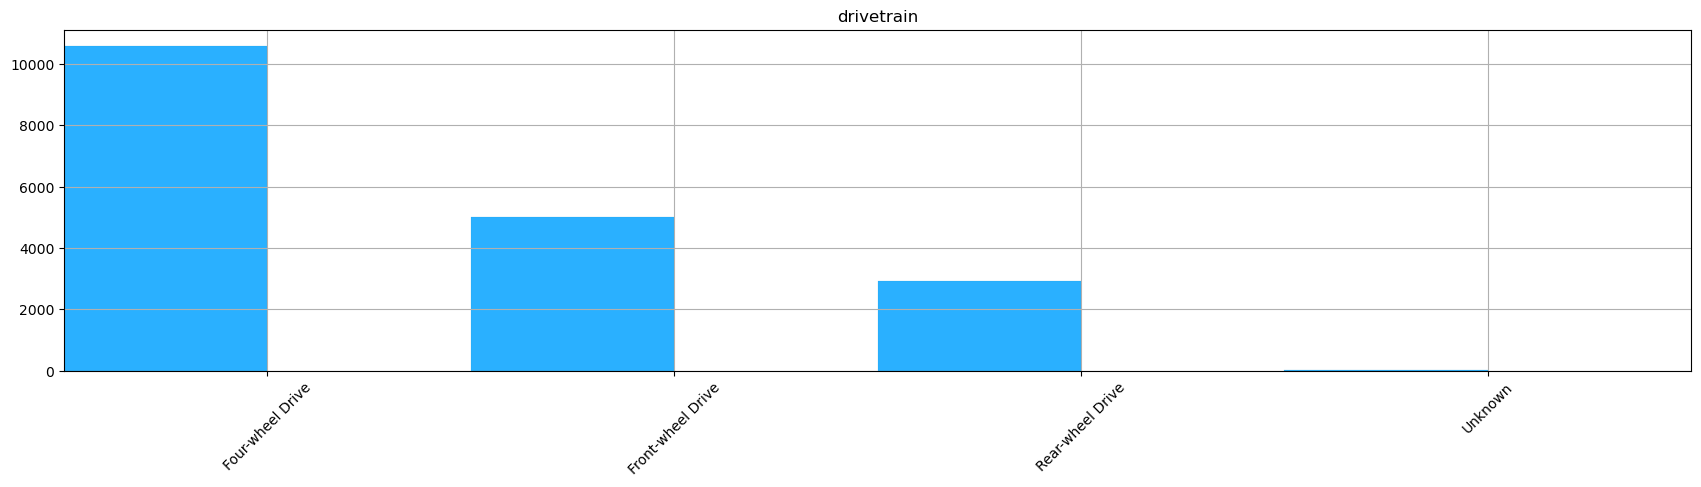

Total number of rows: 18551


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,drivetrain,object,18551,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
soml.pandas.plot.histogram_for_columns(train_csv, column_names="drivetrain")
drivetrain_desc = soml.pandas.dataframe.describe(train_csv, column_names="drivetrain")
drivetrain_desc

So this is actually a not to bad balanced set, four weel drive is a bit overrepresented but we can one-hot encode this.

In [30]:
drivetrain_pipeline = Pipeline(steps=[
    ("drivetrain_sc", OneHotEncoder())
])

# <span style="color:green">Column min_mpg</span>

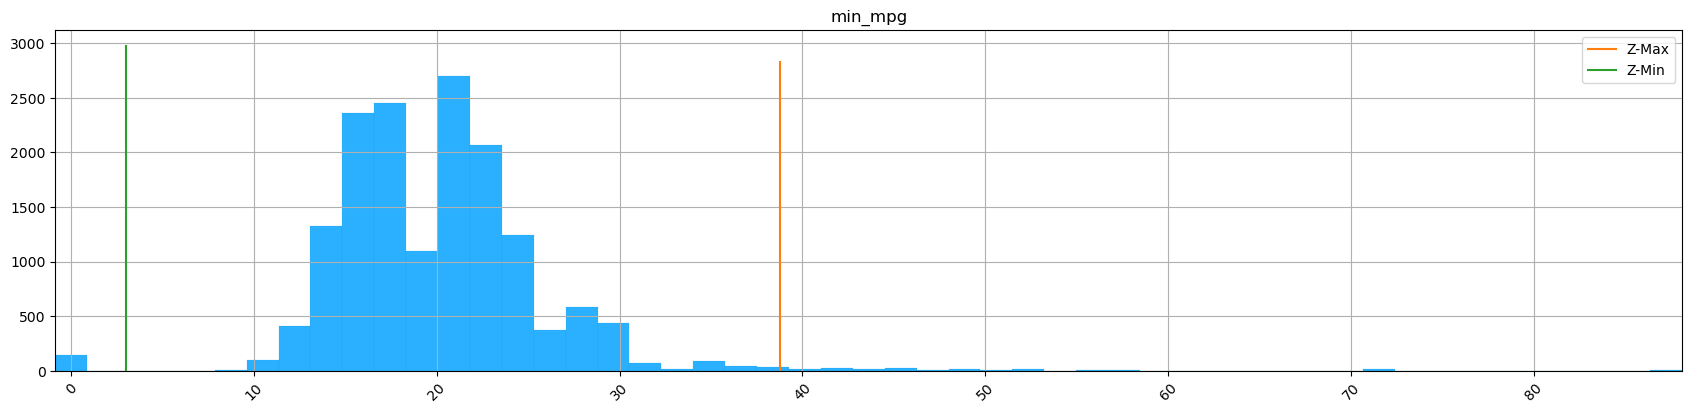

Total number of rows: 18551


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,min_mpg,float64,15726,2825,53,20.87,5.96,3.0,38.75,0.0,17.0,20.0,24.0,89.0


In [31]:
soml.pandas.plot.histogram_for_columns(train_csv, column_names="min_mpg")
min_mpg_desc = soml.pandas.dataframe.describe(train_csv, column_names="min_mpg")
min_mpg_desc

Here we definetly have some outliers, so we will remove those, first let's check how many rows we are going to loose:

In [32]:
to_remove_before = len(train_csv[(train_csv['min_mpg'] < min_mpg_desc['Z-Min'][0])])
to_remove_after = len(train_csv[(train_csv['min_mpg'] > min_mpg_desc['Z-Max'][0])])
to_remove_before, to_remove_after

(147, 198)

So a total of 138 + 109 = 386 rows would be removed. Let's try that and we can always come back and changed the boundaries a bit.

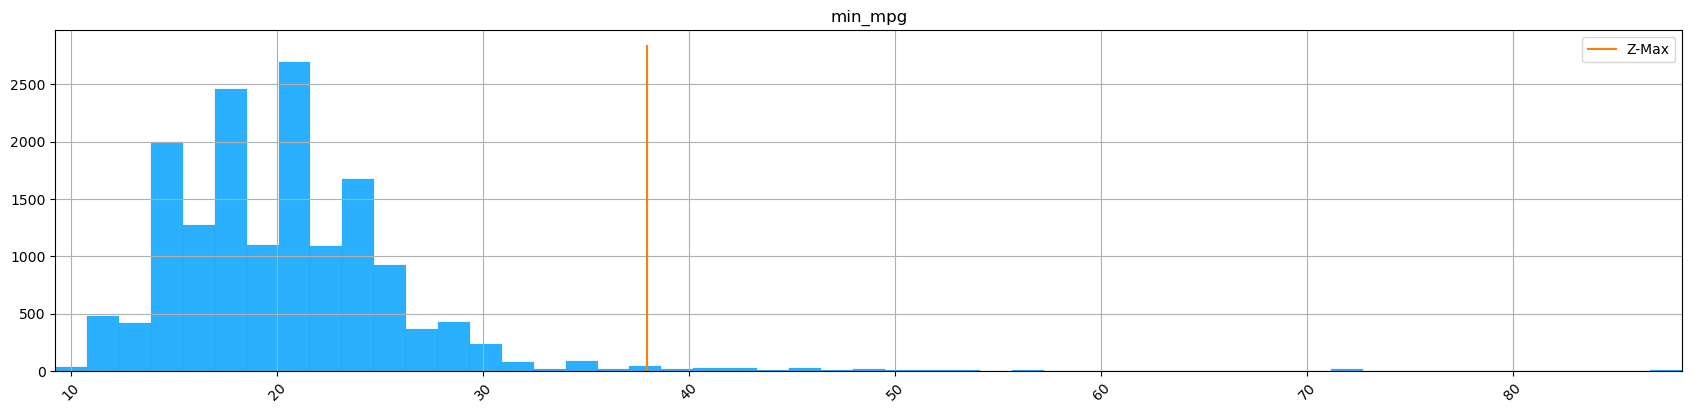

Total number of rows: 18404


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,min_mpg,float64,15579,2825,52,21.07,5.63,4.18,37.96,10.0,17.0,21.0,24.0,89.0


In [33]:
train_csv.drop(train_csv[train_csv['min_mpg'] < min_mpg_desc["Z-Min"][0]].index, inplace = True)
test_csv.drop(test_csv[test_csv['min_mpg'] > min_mpg_desc["Z-Max"][0]].index, inplace = True)

soml.pandas.plot.histogram_for_columns(train_csv, column_names="min_mpg")
soml.pandas.dataframe.describe(train_csv, column_names="min_mpg")

That looks fine, now use a standard scaler.

In [34]:
min_mpg_pipeline = Pipeline(steps=[
    ("min_mpg_im", SimpleImputer()),
    ("min_mpg_sc", MinMaxScaler())
])

# <span style="color:green">Column max_mpg</span>

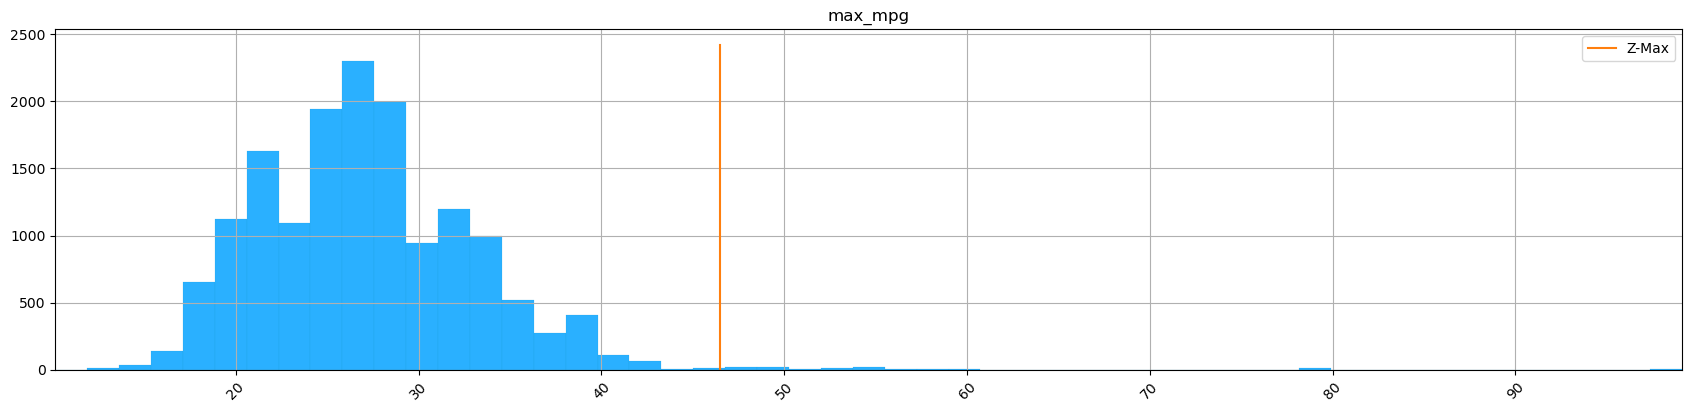

Total number of rows: 18404


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,max_mpg,float64,15579,2825,55,28.02,6.16,9.54,46.51,11.0,24.0,28.0,31.0,100.0


In [35]:
soml.pandas.plot.histogram_for_columns(train_csv, column_names="max_mpg")
max_mpg_desc = soml.pandas.dataframe.describe(train_csv, column_names="max_mpg")
max_mpg_desc

Here we have a few outliers, so we will remove those, and we see some null values so we need to deal with those, first let's check how many rows we are going to loose:

In [36]:
to_remove_before = len(train_csv[(train_csv['max_mpg'] < max_mpg_desc['Z-Min'][0])])
to_remove_after = len(train_csv[(train_csv['max_mpg'] > max_mpg_desc['Z-Max'][0])])
to_remove_before, to_remove_after

(0, 120)

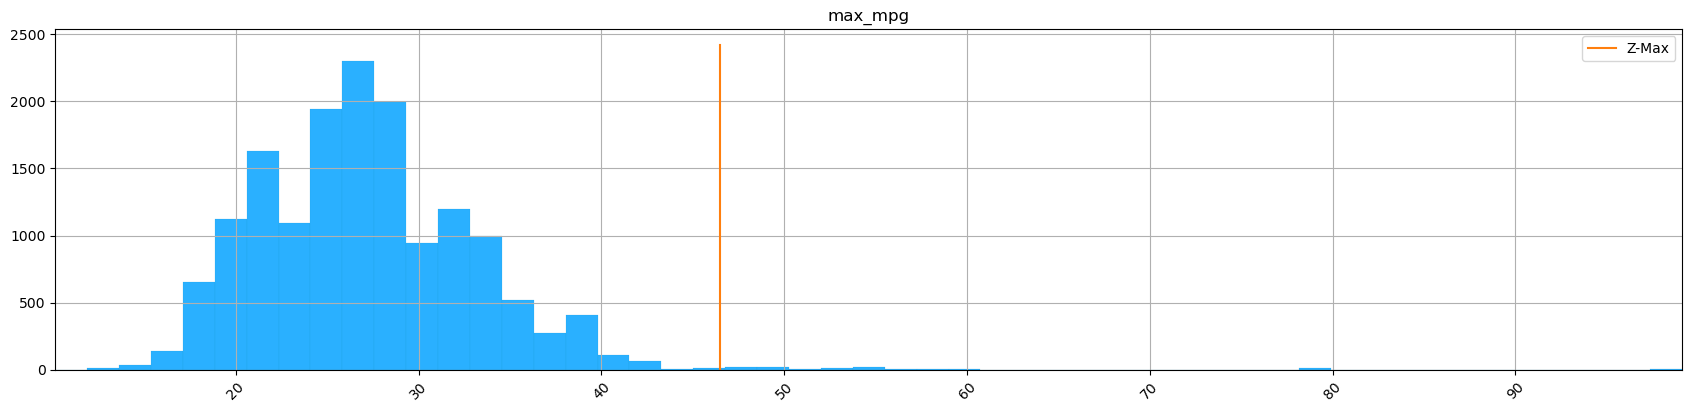

Total number of rows: 18404


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,max_mpg,float64,15579,2825,55,28.02,6.16,9.54,46.51,11.0,24.0,28.0,31.0,100.0


In [37]:
train_csv.drop(train_csv[train_csv['max_mpg'] < max_mpg_desc["Z-Min"][0]].index, inplace = True)
test_csv.drop(test_csv[test_csv['max_mpg'] > max_mpg_desc["Z-Max"][0]].index, inplace = True)

soml.pandas.plot.histogram_for_columns(train_csv, column_names="max_mpg")
soml.pandas.dataframe.describe(train_csv, column_names="max_mpg")

that looks fine, now we will use a Standard scaler for scale the data.

In [38]:
max_mpg_pipeline = Pipeline(steps=[
    ("min_mpg_im", SimpleImputer()),
    ("max_mpg_sc", MinMaxScaler())
])

# <span style="color:green">Column damaged, first_owner, personal_using, turbo, alloy_wheels, adaptive_cruise_control, navigation_system, power_liftgate, backup_camera, keyless_start, sunroof/moonroof, automatic_emergency_breaking, stability_control, leather_seat, memory_seat, third_row_seating, apple_car_play/android_auto, bluetooth, sub_port, heated_seats, automatic_transmission</span>

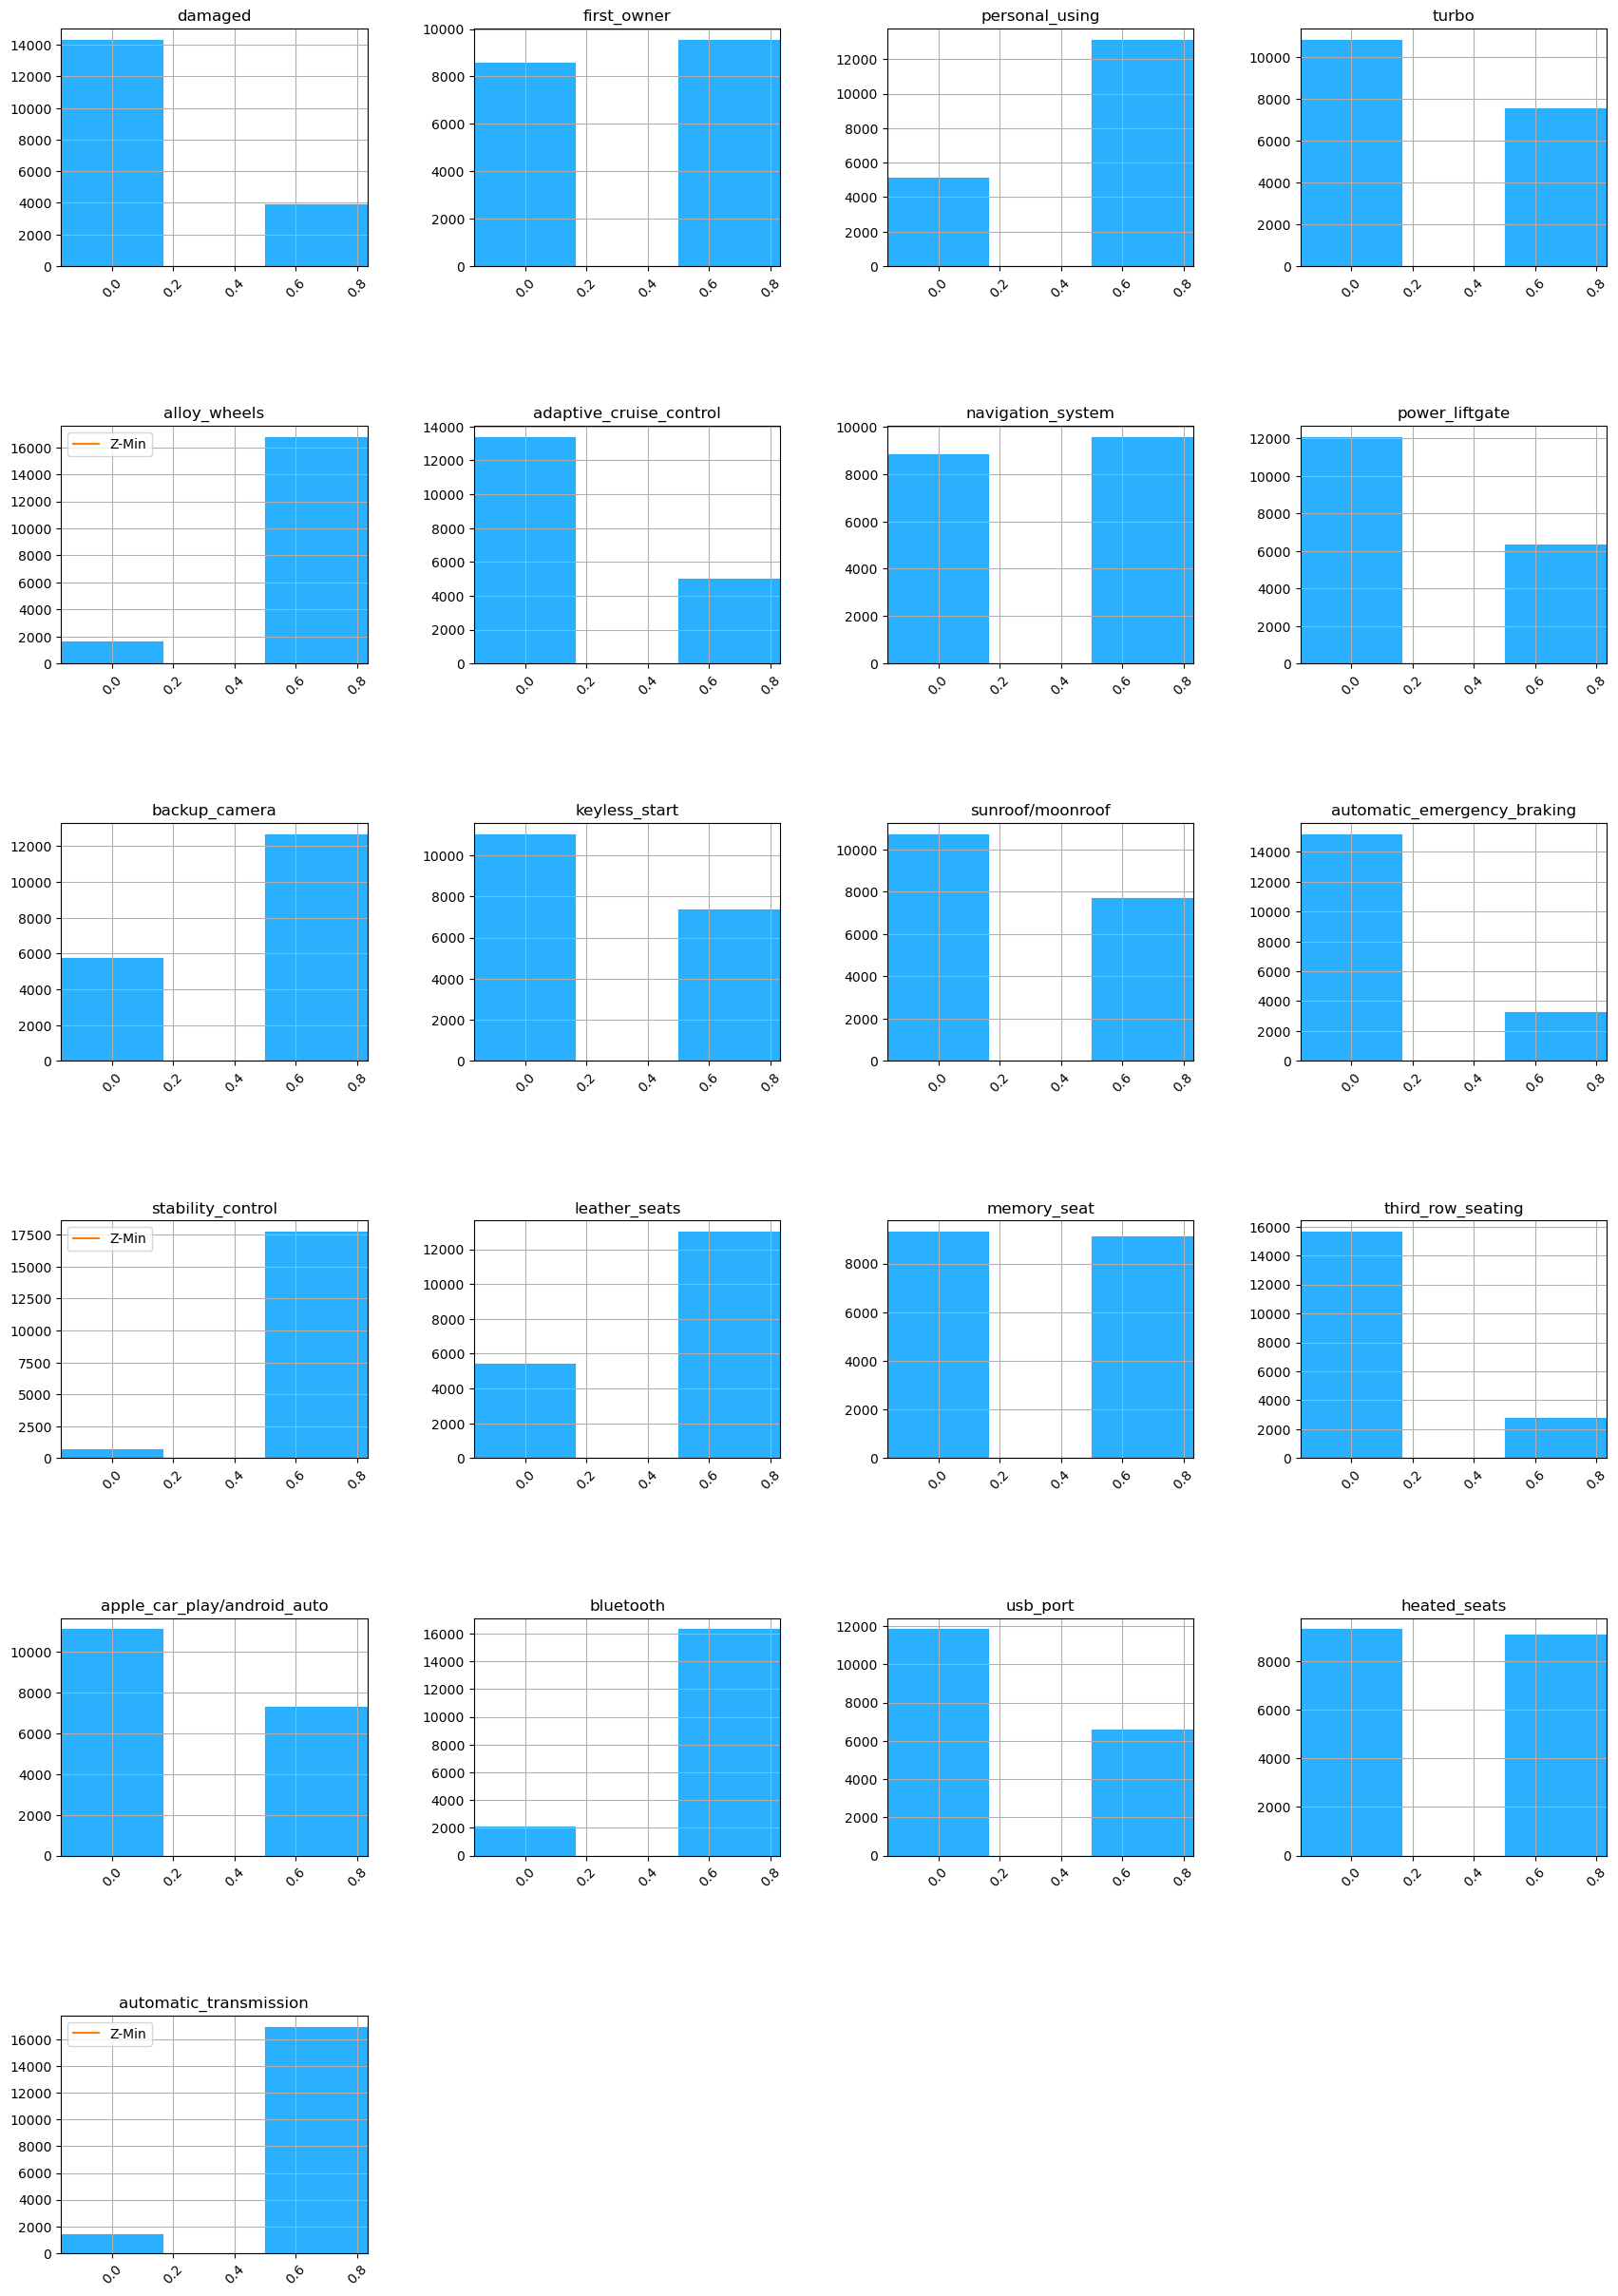

Total number of rows: 18404


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,damaged,float64,18246,158,2,0.22,0.41,-1.02,1.45,0.0,0.0,0.0,0.0,1.0
1,first_owner,float64,18135,269,2,0.53,0.50,-0.97,2.02,0.0,0.0,1.0,1.0,1.0
2,personal_using,float64,18244,160,2,0.72,0.45,-0.63,2.07,0.0,0.0,1.0,1.0,1.0
3,turbo,float64,18404,0,2,0.41,0.49,-1.06,1.89,0.0,0.0,0.0,1.0,1.0
4,alloy_wheels,float64,18404,0,2,0.91,0.29,0.05,1.77,0.0,1.0,1.0,1.0,1.0
5,adaptive_cruise_control,float64,18404,0,2,0.27,0.45,-1.06,1.61,0.0,0.0,0.0,1.0,1.0
6,navigation_system,float64,18404,0,2,0.52,0.50,-0.98,2.02,0.0,0.0,1.0,1.0,1.0
7,power_liftgate,float64,18404,0,2,0.34,0.48,-1.08,1.77,0.0,0.0,0.0,1.0,1.0
8,backup_camera,float64,18404,0,2,0.69,0.46,-0.70,2.08,0.0,0.0,1.0,1.0,1.0
9,keyless_start,float64,18404,0,2,0.40,0.49,-1.07,1.87,0.0,0.0,0.0,1.0,1.0


In [39]:
bool_column_names = ["damaged", "first_owner", "personal_using", "turbo", "alloy_wheels", "adaptive_cruise_control", "navigation_system", "power_liftgate", "backup_camera", "keyless_start", "sunroof/moonroof", "automatic_emergency_braking", "stability_control", "leather_seats", "memory_seat", "third_row_seating", "apple_car_play/android_auto", "bluetooth", "usb_port", "heated_seats", "automatic_transmission"]

soml.pandas.plot.histogram_for_columns(train_csv, column_names=bool_column_names, min_nunique=0, cols=4)
d = soml.pandas.dataframe.describe(train_csv, column_names=bool_column_names)
d

Here we have a lot of boolean values, for now we will use these as is. We do need to do something about the null values so we will use a SimpleImputer for now.

In [40]:
first_owner_pipeline = Pipeline(steps=[
    ("first_owner_im", SimpleImputer(strategy="constant", fill_value=0)),
])

personal_using_pipeline = Pipeline(steps=[
    ("personal_using_im", SimpleImputer(strategy="constant", fill_value=0)),
])

damaged_pipeline = Pipeline(steps=[
    ("damaged_im", SimpleImputer(strategy="constant", fill_value=0)),
])

# <span style="color:green">Column interior_color</span>

In [41]:
soml.pandas.plot.histogram_for_columns(train_csv, column_names="interior_color")
max_mpg_desc = soml.pandas.dataframe.describe(train_csv, column_names="interior_color")
max_mpg_desc

Column 'interior_color' is not visualized, the number of nunique values (925) either exceeds 50 or is lower then 3.


<Figure size 1700x400 with 0 Axes>

Total number of rows: 18404


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,interior_color,object,17337,1067,925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


With 1053 unique string values this column is for now not that interesting, one-hot encoding these results in a lot of parameters, so for now we will drop the column.

# <span style="color:green">Column exterior_color</span>

In [42]:
soml.pandas.plot.histogram_for_columns(train_csv, column_names="exterior_color")
max_mpg_desc = soml.pandas.dataframe.describe(train_csv, column_names="exterior_color")
max_mpg_desc

Column 'exterior_color' is not visualized, the number of nunique values (1875) either exceeds 50 or is lower then 3.


<Figure size 1700x400 with 0 Axes>

Total number of rows: 18404


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,exterior_color,object,18218,186,1875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


With 1865 unique string values this column is for now not that interesting, one-hot encoding these results in a lot of parameters, so for now we will drop the column.

# <span style="color:green">Column price</span>

In [43]:
price_desc = soml.pandas.dataframe.describe(train_csv, column_names="price")
price_desc

Total number of rows: 18404


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,price,object,18404,0,8876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Price seems to be an Object column which is not correct, so we need to change this. First let's check to see if the column only consists of number.

In [44]:
soml.pandas.dataframe.delete_rows_not_number(dataframe=train_csv, column_name="price", inplace=True)
soml.pandas.dataframe.convert_column_as_type(dataframe=train_csv, column_name="price", inplace=True)

soml.pandas.dataframe.delete_rows_not_number(dataframe=test_csv, column_name="price", inplace=True)
soml.pandas.dataframe.convert_column_as_type(dataframe=test_csv, column_name="price", inplace=True)

,brand,model,year,mileage,engine,engine_size,transmission,automatic_transmission,fuel_type,drivetrain,...,leather_seats,memory_seat,third_row_seating,apple_car_play/android_auto,bluetooth,usb_port,heated_seats,interior_color,exterior_color,price
0,FIAT,124 Spider Lusso,2020.0,30830.0,1.4L I4 16V MPFI SOHC Turbo,1.4,6-Speed Automatic,1.0,Gasoline,Rear-wheel Drive,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,Saddle,Forte Black Metallic,26500.0
1,Lexus,RX 450h F Sport,2019.0,58274.0,3.5L V6 24V PDI DOHC Hybrid,3.5,Automatic CVT,1.0,Hybrid,Four-wheel Drive,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,Rioja Red,Nightfall Mica,36987.0
2,Kia,Stinger GT1,2018.0,69303.0,3.3L V6 24V GDI DOHC Twin Turbo,3.3,8-Speed Automatic,1.0,Gasoline,Four-wheel Drive,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,Black,HiChroma Red,26997.0
3,MINI,Convertible Cooper S,2023.0,5026.0,2.0L I4 16V GDI DOHC Turbo,2.0,Automatic,1.0,Gasoline,Front-wheel Drive,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,Carbon Black,Chili Pepper Red,37923.0
4,Nissan,Murano S,2018.0,61180.0,3.5L V6 24V MPFI DOHC,3.5,Automatic CVT,1.0,Gasoline,Four-wheel Drive,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,Graphite,Gun Metallic,20490.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4773,Nissan,GT-R Premium,2015.0,12091.0,"3.8L V-6 DOHC, variable valve control, twin tu...",3.8,Automatic,1.0,Gasoline,Four-wheel Drive,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,Black,Pearl White,92995.0
4774,Maserati,Levante,2021.0,31187.0,3.0L V6 24V GDI DOHC Twin Turbo,3.0,8-Speed Automatic,1.0,Gasoline,Four-wheel Drive,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,Black,White,49850.0
4775,Kia,Optima Hybrid LX,2013.0,86261.0,2.4L I4 16V MPFI DOHC Hybrid,2.4,6-Speed Automatic,1.0,Hybrid,Front-wheel Drive,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Sand / Black,Black,15595.0
4776,Hyundai,Palisade SEL,2020.0,32314.0,3.8L V6 24V GDI DOHC,3.8,8-Speed Automatic,1.0,Gasoline,Front-wheel Drive,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,Gray,Lagoon Silver,34321.0


In [45]:
soml.pandas.dataframe.describe(dataframe=train_csv, column_names="price")

Total number of rows: 18377


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,price,float64,18377,0,8875,37183.13,32884.37,-61469.99,135836.26,1700.0,21300.0,31346.0,43983.0,1650000.0


In [46]:
soml.pandas.dataframe.describe(dataframe=test_csv, column_names="price")

Total number of rows: 4608


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,price,float64,4608,0,3046,36106.88,27072.33,-45110.11,117323.88,1995.0,20775.25,30492.0,42896.25,389900.0


Apperently there are non-number values in the price column, so let's try to find them.

# <span style="color:orange">Final Check</span>

In [47]:
soml.pandas.dataframe.describe(train_csv)

Total number of rows: 18377


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,brand,object,18377,0,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,model,object,18377,0,3287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,year,float64,18377,0,23,2018.20,3.79,2006.85,2029.56,2002.0,2016.0,2019.0,2021.0,2024.0
3,mileage,float64,18377,0,16759,45589.39,34128.06,-56794.78,147973.55,0.0,18841.0,38039.0,66386.0,161447.0
4,engine,object,18350,27,993,45589.39,34128.06,-56794.78,147973.55,0.0,18841.0,38039.0,66386.0,161447.0
5,engine_size,float64,17187,1190,48,2.85,1.15,-0.60,6.30,0.0,2.0,2.5,3.5,6.4
6,transmission,object,18301,76,179,2.85,1.15,-0.60,6.30,0.0,2.0,2.5,3.5,6.4
7,automatic_transmission,float64,18377,0,2,0.92,0.27,0.12,1.73,0.0,1.0,1.0,1.0,1.0
8,fuel_type,object,18377,0,9,0.92,0.27,0.12,1.73,0.0,1.0,1.0,1.0,1.0
9,drivetrain,object,18377,0,4,0.92,0.27,0.12,1.73,0.0,1.0,1.0,1.0,1.0


In [48]:
soml.pandas.dataframe.describe(test_csv)

Total number of rows: 4608


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,brand,object,4608,0,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,model,object,4608,0,1823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,year,float64,4608,0,22,2018.09,3.87,2006.49,2029.69,2002.0,2016.00,2019.0,2021.00,2023.0
3,mileage,float64,4608,0,4501,47307.89,34699.83,-56791.60,151407.38,6.0,19851.00,40053.5,67787.00,159787.0
4,engine,object,4604,4,520,47307.89,34699.83,-56791.60,151407.38,6.0,19851.00,40053.5,67787.00,159787.0
5,engine_size,float64,4336,272,43,2.87,1.17,-0.65,6.38,0.0,2.00,2.5,3.50,6.4
6,transmission,object,4595,13,88,2.87,1.17,-0.65,6.38,0.0,2.00,2.5,3.50,6.4
7,automatic_transmission,float64,4608,0,2,0.92,0.27,0.12,1.72,0.0,1.00,1.0,1.00,1.0
8,fuel_type,object,4608,0,6,0.92,0.27,0.12,1.72,0.0,1.00,1.0,1.00,1.0
9,drivetrain,object,4608,0,4,0.92,0.27,0.12,1.72,0.0,1.00,1.0,1.00,1.0


# <span style="color:orange">Set labels aside before transforming</span>


In [49]:
# Extract the prices as the labels.
train_csv_y = train_csv[["price"]]
test_csv_y = test_csv[["price"]]

soml.pandas.dataframe.drop_columns(train_csv, "price")
soml.pandas.dataframe.drop_columns(test_csv, "price")

# <span style="color:orange">Create the complete pipeline.</span>

In [50]:
set_config(transform_output="default")
ct = make_column_transformer(
    (brand_pipeline, ["brand"]),
    (year_pipeline, ["year"]),
    (mileage_pipeline, ["mileage"]),
    (engine_size_pipeline, ["engine_size"]),
    (drivetrain_pipeline, ["drivetrain"]),
    (min_mpg_pipeline, ["min_mpg"]),
    (max_mpg_pipeline, ["max_mpg"]),
    (first_owner_pipeline, ["first_owner"]),
    (personal_using_pipeline, ["personal_using"]),
    (damaged_pipeline, ["damaged"]),

    # PassColumnTransformer does actually nothing, it just makes sure that the mentioned columns are passed through in case the remainder="drop"
    (mlt.PassColumnTransformer(), ["turbo", "alloy_wheels", "adaptive_cruise_control", "navigation_system", "power_liftgate", "backup_camera", "keyless_start", "sunroof/moonroof", "automatic_emergency_braking", "stability_control", "leather_seats", "memory_seat", "third_row_seating", "apple_car_play/android_auto", "bluetooth", "usb_port", "heated_seats", "automatic_transmission"]),
)

ct.fit(train_csv)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('brand-ohe',
                                                  OneHotEncoder())]),
                                 ['brand']),
                                ('pipeline-2',
                                 Pipeline(steps=[('year_sc', MinMaxScaler())]),
                                 ['year']),
                                ('pipeline-3',
                                 Pipeline(steps=[('mileage_sc',
                                                  MinMaxScaler())]),
                                 ['mileage']),
                                ('pipeline-4',
                                 Pipeline(steps=[('engine_size_im',
                                                  SimpleImputer()),
                                                 ('engine_size_sc',
                                                  MinMaxScaler())]),...
                                 PassColumnTransformer(),
                                 ['turbo', 'alloy_wheels',
                                  'adaptive_cruise_control',
                                  'navigation_system', 'power_liftgate',
                                  'backup_camera', 'keyless_start',
                                  'sunroof/moonroof',
                                  'automatic_emergency_braking',
                                  'stability_control', 'leather_seats',
                                  'memory_seat', 'third_row_seating',
                                  'apple_car_play/android_auto', 'bluetooth',
                                  'usb_port', 'heated_seats',
                                  'automatic_transmission'])])

# <span style="color:orange">Transform training and test data</span>

In [51]:
train_csv_norm = ct.transform(X=train_csv)
test_csv_norm = ct.transform(X=test_csv)

# <span style="color:orange">Check the result of the transformation</span>


In [52]:
train_csv_norm_pd = pd.DataFrame(train_csv_norm, columns=ct.get_feature_names_out())

# Display the details of the dataset.
soml.pandas.dataframe.dataframe_describe(train_csv_norm_pd)

Total number of rows: 18377


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,pipeline-1__brand_Alfa,float64,18377,0,2,0.04,0.20,-0.56,0.64,0.0,0.00,0.00,0.00,1.0
1,pipeline-1__brand_Audi,float64,18377,0,2,0.05,0.21,-0.58,0.67,0.0,0.00,0.00,0.00,1.0
2,pipeline-1__brand_BMW,float64,18377,0,2,0.04,0.20,-0.55,0.63,0.0,0.00,0.00,0.00,1.0
3,pipeline-1__brand_Cadillac,float64,18377,0,2,0.04,0.20,-0.56,0.64,0.0,0.00,0.00,0.00,1.0
4,pipeline-1__brand_Chevrolet,float64,18377,0,2,0.03,0.18,-0.51,0.58,0.0,0.00,0.00,0.00,1.0
5,pipeline-1__brand_FIAT,float64,18377,0,2,0.04,0.20,-0.57,0.65,0.0,0.00,0.00,0.00,1.0
6,pipeline-1__brand_Ford,float64,18377,0,2,0.04,0.19,-0.54,0.62,0.0,0.00,0.00,0.00,1.0
7,pipeline-1__brand_Honda,float64,18377,0,2,0.04,0.20,-0.56,0.64,0.0,0.00,0.00,0.00,1.0
8,pipeline-1__brand_Hyundai,float64,18377,0,2,0.04,0.21,-0.57,0.66,0.0,0.00,0.00,0.00,1.0
9,pipeline-1__brand_Jaguar,float64,18377,0,2,0.04,0.20,-0.56,0.65,0.0,0.00,0.00,0.00,1.0


In [53]:
# (REF #001) Display the first row of the actual data.
train_csv_norm_pd[:1]

,pipeline-1__brand_Alfa,pipeline-1__brand_Audi,pipeline-1__brand_BMW,pipeline-1__brand_Cadillac,pipeline-1__brand_Chevrolet,pipeline-1__brand_FIAT,pipeline-1__brand_Ford,pipeline-1__brand_Honda,pipeline-1__brand_Hyundai,pipeline-1__brand_Jaguar,...,passcolumntransformer__automatic_emergency_braking,passcolumntransformer__stability_control,passcolumntransformer__leather_seats,passcolumntransformer__memory_seat,passcolumntransformer__third_row_seating,passcolumntransformer__apple_car_play/android_auto,passcolumntransformer__bluetooth,passcolumntransformer__usb_port,passcolumntransformer__heated_seats,passcolumntransformer__automatic_transmission
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0


In [54]:
test_csv_norm_pd = pd.DataFrame(test_csv_norm, columns=ct.get_feature_names_out())
soml.pandas.dataframe.dataframe_describe(test_csv_norm_pd)

Total number of rows: 4608


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,pipeline-1__brand_Alfa,float64,4608,0,2,0.04,0.20,-0.55,0.63,0.00,0.00,0.00,0.00,1.00
1,pipeline-1__brand_Audi,float64,4608,0,2,0.04,0.21,-0.58,0.66,0.00,0.00,0.00,0.00,1.00
2,pipeline-1__brand_BMW,float64,4608,0,2,0.04,0.19,-0.54,0.62,0.00,0.00,0.00,0.00,1.00
3,pipeline-1__brand_Cadillac,float64,4608,0,2,0.04,0.20,-0.55,0.63,0.00,0.00,0.00,0.00,1.00
4,pipeline-1__brand_Chevrolet,float64,4608,0,2,0.04,0.18,-0.52,0.59,0.00,0.00,0.00,0.00,1.00
5,pipeline-1__brand_FIAT,float64,4608,0,2,0.05,0.21,-0.58,0.67,0.00,0.00,0.00,0.00,1.00
6,pipeline-1__brand_Ford,float64,4608,0,2,0.04,0.20,-0.57,0.65,0.00,0.00,0.00,0.00,1.00
7,pipeline-1__brand_Honda,float64,4608,0,2,0.04,0.19,-0.53,0.60,0.00,0.00,0.00,0.00,1.00
8,pipeline-1__brand_Hyundai,float64,4608,0,2,0.04,0.20,-0.57,0.66,0.00,0.00,0.00,0.00,1.00
9,pipeline-1__brand_Jaguar,float64,4608,0,2,0.04,0.20,-0.55,0.63,0.00,0.00,0.00,0.00,1.00


In [55]:
soml.pandas.dataframe.dataframe_describe(train_csv_y)

Total number of rows: 18377


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,price,float64,18377,0,8875,37183.13,32884.37,-61469.99,135836.26,1700.0,21300.0,31346.0,43983.0,1650000.0


In [56]:
soml.pandas.dataframe.dataframe_describe(test_csv_y)

Total number of rows: 4608


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,price,float64,4608,0,3046,36106.88,27072.33,-45110.11,117323.88,1995.0,20775.25,30492.0,42896.25,389900.0


### Checklist:

1) No null values in train X/Y and test X/Y.
2) No object data types in train X/Y and test X/Y.
3) Number of rows train X equals number of rows train Y and same for test X and test Y.

# <span style="color:orange">Convert datasets to tensors so we can use them while fitting the data.</span>


In [57]:
train_csv_norm_t = tf.convert_to_tensor(train_csv_norm)
train_csv_y_t = tf.convert_to_tensor(train_csv_y)
test_csv_norm_t = tf.convert_to_tensor(test_csv_norm)
test_csv_y_t = tf.convert_to_tensor(test_csv_y)

Metal device set to: Apple M1 Max


In [58]:
# Look at the first row, we can compare this with REF #001 above (notice the -/+ exponent)
train_csv_norm_t[:1]

<tf.Tensor: shape=(1, 55), dtype=float64, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.90909091, 0.04075641, 0.390625  , 1.        , 0.        ,
        0.        , 0.        , 0.14011298, 0.19125433, 0.        ,
        0.        , 0.        , 1.        , 1.        , 0.        ,
        0.        , 1.        , 1.        , 0.        , 1.        ,
        0.        , 1.        , 1.        , 0.        , 1.        ,
        1.        , 0.        , 0.        , 1.        , 1.        ]])>

# <span style="color:blue">Build First Model</span>

In [59]:
def model_builder(hp: HyperParameter):
    input_layer = Input(shape=([train_csv_norm_t.shape[1]]), name="input_layer")

    dense_1_units = hp.Choice('dense_1_units', [128])
    dense_2_units = hp.Choice('dense_2_units', [128])
    dense_3_units = hp.Choice('dense_3_units', [128])
    dense_4_units = hp.Choice('dense_4_units', [16])
    dense_5_units = hp.Choice('dense_5_units', [8])

    dropout_1_rate = hp.Choice('dropout_1_rate', [0.10, 0.20, 0.30, 0.40])
    dropout_2_rate = hp.Choice('dropout_2_rate', [0.10, 0.20, 0.30, 0.40])
    dropout_3_rate = hp.Choice('dropout_3_rate', [0.10, 0.20, 0.30, 0.40])
    dropout_4_rate = hp.Choice('dropout_4_rate', [0.10, 0.20, 0.30, 0.40])
    dropout_5_rate = hp.Choice('dropout_5_rate', [0.10, 0.20, 0.30, 0.40])

    x = Dense(name="d1", units=dense_1_units, activation="relu")(input_layer)
    x = Dropout(rate=dropout_1_rate)(x)
    x = Dense(name="d2", units=dense_2_units, activation="relu")(x)
    x = Dropout(rate=dropout_2_rate)(x)
    x = Dense(name="d3", units=dense_3_units, activation="relu")(x)
    x = Dropout(rate=dropout_3_rate)(x)
    x = Dense(name="d4", units=dense_4_units, activation="relu")(x)
    x = Dropout(rate=dropout_4_rate)(x)
    x = Dense(name="d5", units=dense_5_units, activation="relu")(x)
    x = Dropout(rate=dropout_5_rate)(x)
    output_layer = Dense(units=1, activation="relu", name="output_layer")(x)

    model = Model(input_layer, output_layer)

    model.compile(loss=mean_absolute_error,
                  optimizer=Adam(lr=0.005),
                  metrics=["mae"])

    return model


In [62]:
early_stopping_callback = soml.tf.model.callback.early_stopping_callback()
reduce_lr_callback = soml.tf.model.callback.reduce_lr_on_plateau_callback()

In [68]:
input_layer = Input(shape=([train_csv_norm_t.shape[1]]), name="input_layer")
x = Dense(name="d1", units=128, activation="relu")(input_layer)
x = Dropout(rate=.2)(x)
x = Dense(name="d2", units=128, activation="relu")(x)
x = Dropout(rate=.4)(x)
x = Dense(name="d3", units=128, activation="relu")(x)
x = Dropout(rate=.3)(x)
x = Dense(name="d4", units=16, activation="relu")(x)
x = Dropout(rate=.4)(x)
x = Dense(name="d5", units=8, activation="relu")(x)
x = Dropout(rate=.3)(x)
output_layer = Dense(units=1, activation="relu", name="output_layer")(x)

model = Model(input_layer, output_layer)

model.compile(loss=mean_absolute_error,
              optimizer=Adam(lr=0.005),
              metrics=["mae"])

history = model.fit(train_csv_norm_t,
                    train_csv_y_t,
                    batch_size=32,
                    epochs=100,
                    validation_data=(test_csv_norm_t, test_csv_y_t),
                    callbacks=[early_stopping_callback, reduce_lr_callback])

Epoch 1/100
575/575 [==============================] - 8s 12ms/step - loss: 10747.6338 - mae: 10747.6338 - val_loss: 6726.4409 - val_mae: 6726.4409 - lr: 0.0050
Epoch 2/100
575/575 [==============================] - 8s 14ms/step - loss: 7148.6240 - mae: 7148.6240 - val_loss: 7320.9697 - val_mae: 7320.9697 - lr: 0.0050
Epoch 3/100
575/575 [==============================] - 8s 14ms/step - loss: 6727.4639 - mae: 6727.4639 - val_loss: 7277.2241 - val_mae: 7277.2241 - lr: 0.0050
Epoch 4/100
575/575 [==============================] - 8s 13ms/step - loss: 6561.7598 - mae: 6561.7598 - val_loss: 9143.8008 - val_mae: 9143.8008 - lr: 0.0050
Epoch 5/100
575/575 [==============================] - 8s 13ms/step - loss: 6325.9561 - mae: 6325.9561 - val_loss: 6656.3457 - val_mae: 6656.3457 - lr: 0.0050
Epoch 6/100
575/575 [==============================] - 7s 13ms/step - loss: 6247.0298 - mae: 6247.0298 - val_loss: 6569.7012 - val_mae: 6569.7012 - lr: 0.0050
Epoch 7/100
575/575 [=======================

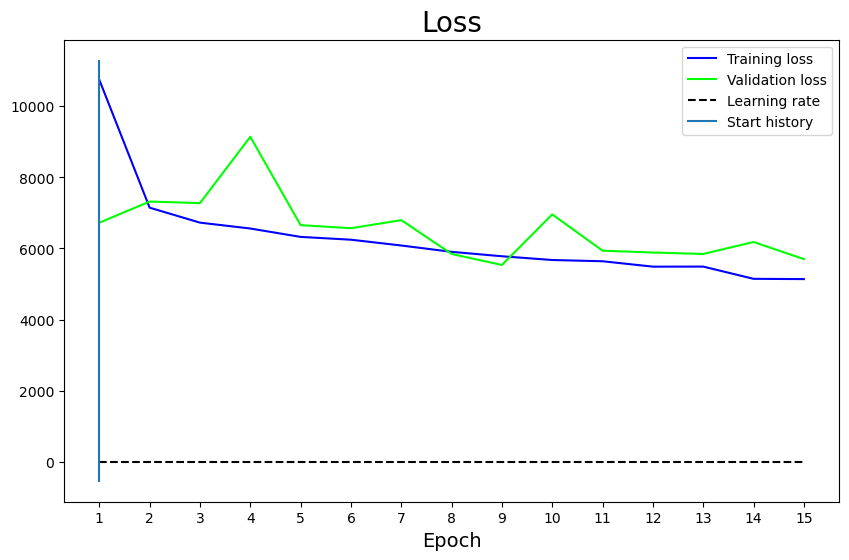

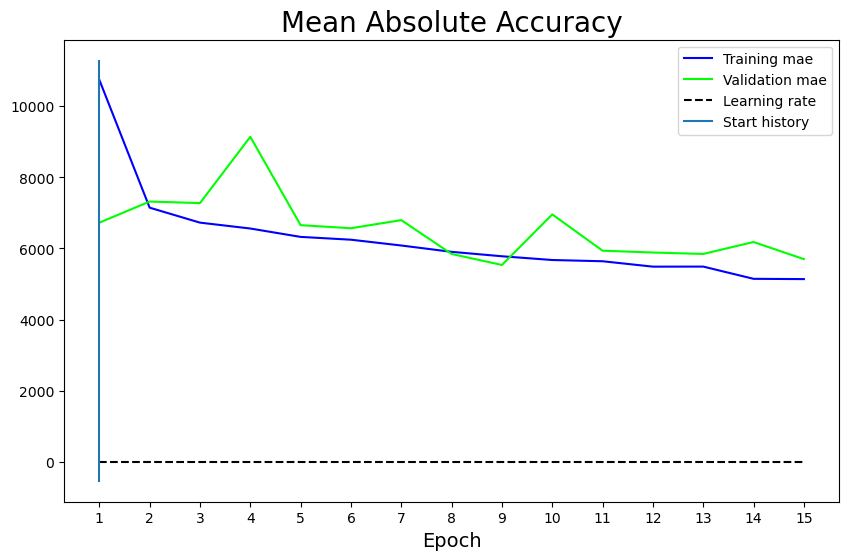

In [69]:
soml.tf.model.plot.history(history=history)

In [79]:
y_pred = soml.tf.model.predict.regression(model, test_csv_norm_t)

1/1 [==============================] - 0s 11ms/step


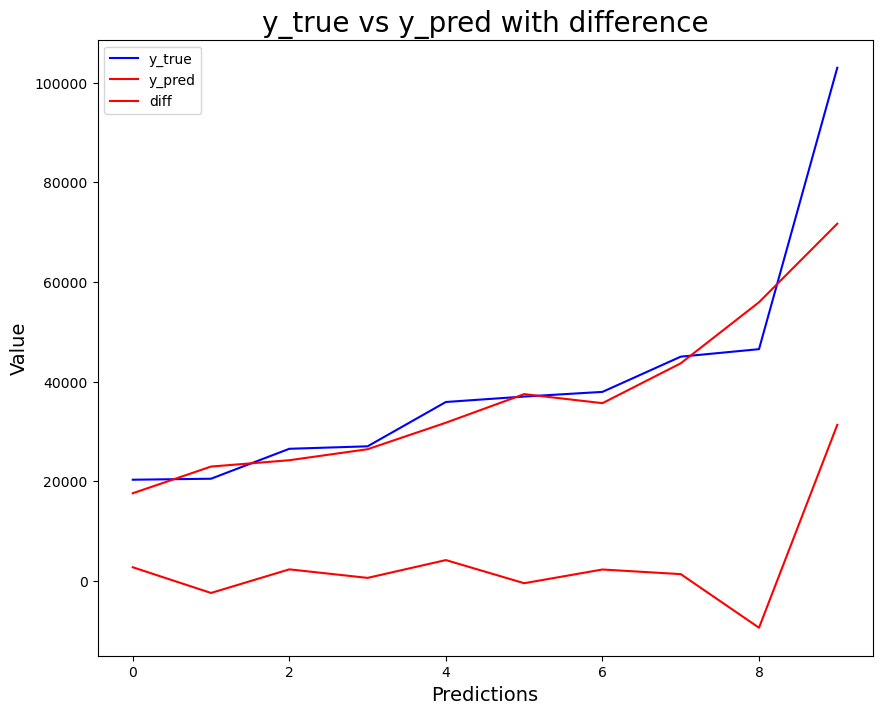

In [121]:
mlp.plot_regression_y_pred_vs_y_true(test_csv_y[:10], y_pred.round(0)[:10])

In [177]:
soml.regression.evaluate.determine_outliers(x=test_csv, y_true=test_csv_y, y_pred=y_pred)

,brand,model,year,mileage,engine,engine_size,transmission,automatic_transmission,fuel_type,drivetrain,...,third_row_seating,apple_car_play/android_auto,bluetooth,usb_port,heated_seats,interior_color,exterior_color,y_true,y_pred,diff
1859,Mercedes-Benz,AMG GT C,2021.0,2050.0,"AMG 4L V-8 gasoline direct injection, DOHC, va...",NaN,Automatic,1.0,Gasoline,Rear-wheel Drive,...,0.0,1.0,1.0,1.0,1.0,Black,designo Graphite Gray Magno,389900.0,76607.0,313293.0
2184,Mercedes-Benz,SLS AMG Base,2011.0,21213.0,6.2L V8 32V MPFI DOHC,6.2,7-Speed Automatic with Auto-Shift,1.0,Gasoline,Rear-wheel Drive,...,0.0,0.0,1.0,0.0,0.0,Classic Red,Iridium Silver Metallic,216990.0,65639.0,151351.0
4526,BMW,XM,2023.0,754.0,4.4L V8,4.4,Automatic,1.0,Gasoline,Four-wheel Drive,...,0.0,0.0,0.0,0.0,0.0,Black,Bay Blue,249895.0,102385.0,147510.0
2754,Cadillac,Escalade ESV Sport Platinum,2023.0,277.0,6.2L V8 16V GDI OHV,6.2,10-Speed Automatic with Overdrive,1.0,Gasoline,Four-wheel Drive,...,0.0,0.0,0.0,0.0,0.0,Black,Black,249950.0,105040.0,144910.0
1414,Mercedes-Benz,SLS AMG Base,2011.0,13422.0,6.2L V8 32V MPFI DOHC,6.2,7-Speed Automatic with Auto-Shift,1.0,Gasoline,Rear-wheel Drive,...,0.0,0.0,1.0,0.0,0.0,Red,Silver,213990.0,82458.0,131532.0
1822,Porsche,911 Turbo S,2023.0,1972.0,3.8L H6 24V GDI DOHC Twin Turbo,3.8,8-Speed Automatic,1.0,Gasoline,Four-wheel Drive,...,0.0,0.0,0.0,0.0,1.0,Slate Gray,Gentian Blue Metallic,279999.0,150853.0,129146.0
2312,Land,Rover Range Rover Autobiography,2023.0,2748.0,4.4L V8 32V GDI DOHC Twin Turbo,4.4,Automatic,1.0,Gasoline,Four-wheel Drive,...,0.0,0.0,1.0,0.0,1.0,SV Bespoke Ebony,Santorini Black,221000.0,93929.0,127071.0
2960,Porsche,911 Turbo S,2022.0,5922.0,3.8L H6 24V GDI DOHC Twin Turbo,3.8,8-Speed Automatic with Auto-Shift,1.0,Gasoline,Four-wheel Drive,...,0.0,0.0,1.0,0.0,1.0,Black,Silver,262950.0,136935.0,126015.0
2648,Porsche,911 GT3 RS,2019.0,13042.0,"4L H-6 gasoline direct injection, DOHC, VarioC...",4.0,Automatic,1.0,Gasoline,Rear-wheel Drive,...,0.0,1.0,1.0,1.0,0.0,Black,White,254888.0,130371.0,124517.0
763,Land,Rover Range Rover SV,2023.0,303.0,4.4L V8 32V GDI DOHC Twin Turbo,4.4,Automatic,1.0,Gasoline,Four-wheel Drive,...,0.0,0.0,1.0,0.0,1.0,Ebony,Velocity Blue,249995.0,132051.0,117944.0
